# E-Commerce Order Success & Revenue Optimization Model


The model below is designed to demonstrate how changes in our e-commerce funnel metrics affect core KPIs and top-line revenue. Specifically, it simulates how decreasing customer drop-off at specific touchpoints (e.g., viewing a product vs. adding it to the cart) impacts our gross purchase revenue.

The model relies on set constants derived from our historical 2024-2025 event data to establish a "baseline" or usual fallout amount between workflow points. This allows us to simulate the financial impact of UI/UX improvements or marketing changes.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Date.csv to Date.csv
Saving Events.csv to Events.csv
Saving Product.csv to Product.csv
Saving Traffic.csv to Traffic.csv
Saving Users.csv to Users.csv


In [3]:
df_events = pd.read_csv('Events.csv')

Function Inputs:

 * **inc_traffic:** Amount to increase total Top-of-Funnel Page Views by (raw #)

 * **inc_cart_rate:** Amount to increase the View-to-Cart Rate by (%, should be between 0 & 1)

 * **inc_checkout_rate:** Amount to increase the Cart-to-Checkout Rate by (%, should be between 0 & 1)

 * **inc_payment_rate:** Amount to increase the Checkout-to-Payment Info Rate by (%, should be between 0 & 1)

 * **inc_purchase_rate:** Amount to increase the Payment-to-Purchase Rate by (%, should be between 0 & 1)


Function Outputs:

 * **Total Top-of-Funnel Traffic:** Total number of product page views.

 * **Total Purchases:** Total number of successful transactions completed.

 * **Stage-to-Stage Pullthrough:** The % of users who progress from one specific step to the immediate next step.

 * **Overall Funnel Conversion:** The % of total purchases out of the total initial page views.

 * **Projected Revenue:** Total Gross Revenue based on Average Order Value (AOV).





NOTE:

The model is produced based on baseline metrics from the full 2024-2025 dataset. Each change/increase put into the model will use these historical averages as a starting point.

In [4]:
df_events


,Event_ID,Date_ID,User_ID,Item_ID,Traffic_Source_ID,Event_Name,Purchase_Revenue,Session_Duration_Seconds,Previous_Purchases_Count,Discount_Code_Used,Page_Layout_Version
0,1,20240101,14563,120,1,page_view,NaN,39,0,False,Control
1,2,20240101,14563,108,1,page_view,NaN,25,0,False,Control
2,3,20240101,14563,124,1,page_view,NaN,24,0,False,Control
3,4,20240101,14563,124,1,add_to_cart,NaN,104,0,False,Control
4,5,20240101,1879,110,1,page_view,NaN,13,0,False,Control
...,...,...,...,...,...,...,...,...,...,...,...
1834743,1834744,20251231,50015,106,2,page_view,NaN,41,1,False,Variant B
1834744,1834745,20251231,50834,118,1,page_view,NaN,39,3,False,Control
1834745,1834746,20251231,2324,103,2,page_view,NaN,26,3,False,Control
1834746,1834747,20251231,2324,103,2,add_to_cart,NaN,78,3,False,Control


## The Math behind this :

These equations together form a system of equations. The Cs are unknown constants, or in other words, the function inputs that the user decides to simulate in the model. The multipliers are our historical baseline conversion rates.

System of Equations:

**v = Total Page Views + Cv**

**w = v * (Baseline Cart Rate + Cw)**

**x = w * (Baseline Checkout Rate + Cx)**

**y = x * (Baseline Payment Rate + Cy)**

**z = y * (Baseline Purchase Rate + Cz)**

**Revenue = z * Baseline Average Order Value (AOV)**


The final variable z represents the raw count of completed purchases. We can then use these raw counts to model revenue, pullthrough, and conversion.

In [5]:
#  raw counts for each stage of the funnel
page_views = len(df_events[df_events['Event_Name'] == 'page_view'])
adds_to_cart = len(df_events[df_events['Event_Name'] == 'add_to_cart'])
checkouts = len(df_events[df_events['Event_Name'] == 'begin_checkout'])
payments = len(df_events[df_events['Event_Name'] == 'add_payment_info'])
purchases = len(df_events[df_events['Event_Name'] == 'purchase'])

print("Total Page Views:", page_views, "\nTotal Adds to Cart:", adds_to_cart, "\nTotal Checkouts:",
      checkouts, "\nTotal Payments:", payments, "\nTotal Purchases:", purchases)

Total Page Views: 856929 
Total Adds to Cart: 341557 
Total Checkouts: 259798 
Total Payments: 220664 
Total Purchases: 155800


In [6]:
# Baseline Conversion Rates
base_cart_rate = adds_to_cart / page_views
base_checkout_rate = checkouts / adds_to_cart
base_payment_rate = payments / checkouts
base_purchase_rate = purchases / payments

print("Baseline Cart Rate:", base_cart_rate, "\nBaseline Checkout Rate:", base_checkout_rate, "\nBaseline Payment Rate:",
      base_payment_rate, "\nBaseline Purchase Rate:", base_purchase_rate)

Baseline Cart Rate: 0.3985826130286173 
Baseline Checkout Rate: 0.7606285334512248 
Baseline Payment Rate: 0.8493675855857243 
Baseline Purchase Rate: 0.7060508284088025


In [7]:
# Baseline Average Order Value (AOV)
# Filter for actual purchases and calculate the mean revenue
purchase_events = df_events[df_events['Event_Name'] == 'purchase']
baseline_aov = purchase_events['Purchase_Revenue'].mean()
baseline_total_revenue = purchase_events['Purchase_Revenue'].sum()

# Baselines for our Model
print("--- BASELINE SYSTEM OF EQUATION CONSTANTS ---")
print(f"Starting Page Views (v): {page_views:,}")
print(f"Base Cart Rate: {base_cart_rate:.4f} (or {base_cart_rate*100:.2f}%)")
print(f"Base Checkout Rate: {base_checkout_rate:.4f} (or {base_checkout_rate*100:.2f}%)")
print(f"Base Payment Rate: {base_payment_rate:.4f} (or {base_payment_rate*100:.2f}%)")
print(f"Base Purchase Rate: {base_purchase_rate:.4f} (or {base_purchase_rate*100:.2f}%)")
print(f"Baseline AOV: ${baseline_aov:.2f}")
print(f"\nBaseline Total Revenue: ${baseline_total_revenue:,.2f}")

--- BASELINE SYSTEM OF EQUATION CONSTANTS ---
Starting Page Views (v): 856,929
Base Cart Rate: 0.3986 (or 39.86%)
Base Checkout Rate: 0.7606 (or 76.06%)
Base Payment Rate: 0.8494 (or 84.94%)
Base Purchase Rate: 0.7061 (or 70.61%)
Baseline AOV: $268.58

Baseline Total Revenue: $41,844,967.78


## E-Commerce Order Success Model

The function below, ecommerce_success, models e-commerce completion metrics based on the given inputs. The function is designed to demonstrate how changes in the website workflow metrics can affect our KPIs and gross revenue (i.e., how decreasing fallout at certain points in the checkout workflow can impact revenue).

The model relies on the baseline constants calculated above (which represent our usual fallout amount between workflow points). This will help us simulate the impact of UI/UX improvements on revenue.

Solution for baseline (no changes/increases from baseline/2024-2025 data):

**v = Current Total Page Views**

**w = (Current Cart Rate * v)**

**x = (Current Checkout Rate * w)**

**y = (Current Payment Rate * x)**

**z = (Current Purchase Rate * y)**

In [8]:
def ecommerce_success(inc_traffic, inc_cart_rate, inc_checkout_rate, inc_payment_rate, inc_purchase_rate, labels):

    # Apply the absolute increases to our baseline volumes and rates
    v = page_views + inc_traffic
    w = v * (base_cart_rate + inc_cart_rate)
    x = w * (base_checkout_rate + inc_checkout_rate)
    y = x * (base_payment_rate + inc_payment_rate)
    z = int(y * (base_purchase_rate + inc_purchase_rate)) # Final purchases must be a whole number

    # Calculate KPIs
    pullthrough = str(round((z * 100) / y, 2)) + '%'  # Purchase rate from the final payment step
    overall_conversion = str(round((z * 100) / v, 2)) + '%' # Total purchases / Total page views
    revenue = z * baseline_aov

    # Return with or without text labels based on the input
    if labels == 1:
        return ['Page Views: ' + str(int(v)),
                'Purchases Completed: ' + str(z),
                'Payment-to-Purchase Pullthrough: ' + pullthrough,
                'Overall Conversion: ' + overall_conversion,
                'Revenue: $' + str(round(revenue, 2))]
    else:
        return [int(v), z, pullthrough, overall_conversion, round(revenue, 2)]

# Test the function with our baseline (setting all increases to 0)
print(ecommerce_success(0, 0, 0, 0, 0, labels=1))

['Page Views: 856929', 'Purchases Completed: 155800', 'Payment-to-Purchase Pullthrough: 70.61%', 'Overall Conversion: 18.18%', 'Revenue: $41844967.78']


## Baseline vs. Increase Model Comparison

Below, we define the baseline (all increase amounts set to 0) and the increase_model. Any change in values can be input into the increase_model, and the changes will be reflected in the Data Frame.

Scenario: What happens if our marketing team drives an extra 50,000 top-of-funnel page views, AND our Product team improves the "Add to Cart" conversion rate by 5% (0.05)? Let's compare this directly against the baseline.

In [9]:
# Baseline defined by setting all changes to 0.
baseline = ecommerce_success(0, 0, 0, 0, 0, labels=0)

# Edit model below by inputting increase amounts:
# Parameters: (inc_traffic, inc_cart_rate, inc_checkout_rate, inc_payment_rate, inc_purchase_rate, labels)
# Example: +50,000 traffic, +5% (0.05) cart rate, everything else 0
increase_model = ecommerce_success(50000, 0.05, 0, 0, 0, labels=0)

# Create the DataFrame
model_data = pd.DataFrame([baseline, increase_model],
                          columns=['Total Page Views', 'Completed Purchases', 'Payment Pullthrough', 'Overall Conversion', 'Revenue'])

# Add row headers
row_headers = ['Baseline (Historical Data)', 'Model (Based on Inputs)']
model_data.index = row_headers

# Format Revenue column for better readability
pd.options.display.float_format = '${:,.2f}'.format

model_data

,Total Page Views,Completed Purchases,Payment Pullthrough,Overall Conversion,Revenue
Baseline (Historical Data),856929,155800,70.61%,18.18%,"$41,844,967.78"
Model (Based on Inputs),906929,185575,70.6%,20.46%,"$49,841,976.22"


## Isolated Variable Impact on Revenue

Below, isolated revenue impacts are created for each input by increasing the metric by 1% (or a 1% volume increase for top-of-funnel traffic) and holding all of the other inputs constant (setting the rest to 0).

This models the amount of revenue that will be generated with a 1% improvement in that specific stage of the e-commerce funnel, with all other variables held at their historical baseline.

In [10]:
# 1. Calculate the baseline revenue (all increases set to 0)
baseline_rev = ecommerce_success(0, 0, 0, 0, 0, labels=0)[4]

# 2. Calculate isolated revenues for a 1% increase in each stage
# Note: For traffic, we calculate 1% of the total baseline page_views
oneperc_traffic_inc = int(page_views * 0.01)

oneperc_traffic_rev = ecommerce_success(oneperc_traffic_inc, 0, 0, 0, 0, labels=0)[4]
oneperc_cart_rev = ecommerce_success(0, 0.01, 0, 0, 0, labels=0)[4]
oneperc_checkout_rev = ecommerce_success(0, 0, 0.01, 0, 0, labels=0)[4]
oneperc_payment_rev = ecommerce_success(0, 0, 0, 0.01, 0, labels=0)[4]
oneperc_purchase_rev = ecommerce_success(0, 0, 0, 0, 0.01, labels=0)[4]

# 3. Calculate the difference (Revenue Lift) from the baseline
diff_traffic = oneperc_traffic_rev - baseline_rev
diff_cart = oneperc_cart_rev - baseline_rev
diff_checkout = oneperc_checkout_rev - baseline_rev
diff_payment = oneperc_payment_rev - baseline_rev
diff_purchase = oneperc_purchase_rev - baseline_rev

# 4. Create lists for our DataFrame and visualization
rows = ['+1% Page Views', '+1% View-to-Cart', '+1% Cart-to-Checkout', '+1% Checkout-to-Payment', '+1% Payment-to-Purchase']
diffs_list = [diff_traffic, diff_cart, diff_checkout, diff_payment, diff_purchase]
total_revenues = [oneperc_traffic_rev, oneperc_cart_rev, oneperc_checkout_rev, oneperc_payment_rev, oneperc_purchase_rev]

# 5. Build the DataFrame
impact_df = pd.DataFrame({
    'Metric with 1% Improvement': rows,
    'Total Projected Revenue': total_revenues,
    'Difference from Baseline (Lift)': diffs_list
})

# Format for currency
pd.options.display.float_format = '${:,.2f}'.format
impact_df

,Metric with 1% Improvement,Total Projected Revenue,Difference from Baseline (Lift)
0,+1% Page Views,"$42,263,148.87","$418,181.09"
1,+1% View-to-Cart,"$42,894,583.53","$1,049,615.75"
2,+1% Cart-to-Checkout,"$42,395,022.30","$550,054.52"
3,+1% Checkout-to-Payment,"$42,337,545.90","$492,578.12"
4,+1% Payment-to-Purchase,"$42,437,458.14","$592,490.36"


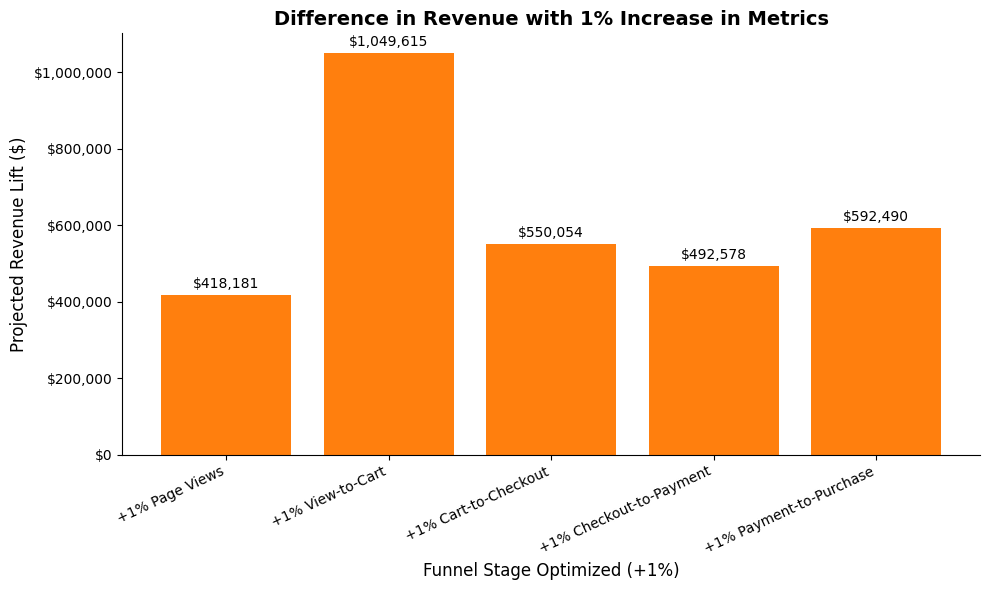

In [11]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

# Setup the figure size and style
plt.figure(figsize=(10, 6))

# Create the bar chart
bars = plt.bar(rows, diffs_list, color='#ff7f0e') # Using an orange hex code that matches your Power BI dashboard!

# Formatting the chart
plt.xticks(rotation=25, ha='right')
plt.ylabel('Projected Revenue Lift ($)', fontsize=12)
plt.xlabel('Funnel Stage Optimized (+1%)', fontsize=12)
plt.title('Difference in Revenue with 1% Increase in Metrics', fontsize=14, fontweight='bold')

# Format the y-axis to show millions/thousands clearly
formatter = ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Add data labels directly on top of the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(diffs_list)*0.01),
             f'${int(yval):,}', ha='center', va='bottom', fontsize=10)

# Remove top and right borders for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Conclusion & Recommendation:

Based on the isolated variable sensitivity analysis, improving the Top-of-Funnel "Page View to Add to Cart" conversion rate by 1% yields the largest increase in gross revenue. Therefore, engineering and design resources should be prioritized toward A/B testing the product detail pages (e.g., sticky cart buttons, better product images, or visible customer reviews) rather than optimizing the downstream checkout or payment pages.

# Exploratory: Testing Hypothetical Situations

The function below, ecommerce_hypotheticals, takes the raw inputs (not the increases like the functions above) for traffic, cart_rate, checkout_rate, payment_rate, and purchase_rate.

We will model a few hypothetical situations to explore the compounding effect on revenue:

Baseline: Our historical 2024-2025 performance.

Aggressive Marketing: What happens if we drive 2,500,000 Page Views but conversion rates stay exactly the same?

Cart Optimization: A 5% absolute increase in the View-to-Cart rate, all else constant.

The "Dream" Scenario: A 5% absolute increase across every single stage of the funnel.

The Mega-Scale: Double the total traffic AND a 5% increase in the View-to-Cart rate.

In [12]:
# Function takes raw input numbers and outputs core metrics and revenue
def ecommerce_hypotheticals(traffic, cart_rate, checkout_rate, payment_rate, purchase_rate):

    v = traffic
    w = v * cart_rate
    x = w * checkout_rate
    y = x * payment_rate
    z = int(round(y * purchase_rate, 0)) # Purchases must be whole numbers

    overall_conversion = str(round((z * 100) / v, 2)) + '%'
    revenue = round(z * baseline_aov, 2)

    return [int(v), z, overall_conversion, revenue]

In [13]:
# Baseline using our exact historical rates
baseline_hypo = ecommerce_hypotheticals(page_views, base_cart_rate, base_checkout_rate, base_payment_rate, base_purchase_rate)

# Aggressive Marketing (Scaling traffic to 2.5 Million)
scale_traffic = ecommerce_hypotheticals(2500000, base_cart_rate, base_checkout_rate, base_payment_rate, base_purchase_rate)

# Cart Optimization (+5% to Cart Rate only)
five_pct_cart = ecommerce_hypotheticals(page_views, base_cart_rate + 0.05, base_checkout_rate, base_payment_rate, base_purchase_rate)

# The Dream Scenario (+5% to all rates)
five_pct_all = ecommerce_hypotheticals(page_views, base_cart_rate + 0.05, base_checkout_rate + 0.05, base_payment_rate + 0.05, base_purchase_rate + 0.05)

# Mega-Scale (Double Traffic + 5% Cart Rate)
mega_scale = ecommerce_hypotheticals(page_views * 2, base_cart_rate + 0.05, base_checkout_rate, base_payment_rate, base_purchase_rate)


# Build the DataFrame
row_headers = [
    '1. Baseline',
    '2. Drive 2.5M Page Views',
    '3. +5% View-to-Cart Rate',
    '4. +5% Increase to ALL Rates',
    '5. Double Traffic & +5% Cart Rate'
]

hypo_data = pd.DataFrame([baseline_hypo, scale_traffic, five_pct_cart, five_pct_all, mega_scale],
                         columns = ['Total Page Views', 'Completed Purchases', 'Overall Conversion', 'Revenue'])
hypo_data.index = row_headers

# Format Revenue
pd.options.display.float_format = '${:,.2f}'.format

hypo_data

,Total Page Views,Completed Purchases,Overall Conversion,Revenue
1. Baseline,856929,155800,18.18%,"$41,844,967.78"
2. Drive 2.5M Page Views,2500000,454530,18.18%,"$122,078,261.90"
3. +5% View-to-Cart Rate,856929,175344,20.46%,"$47,094,120.86"
4. +5% Increase to ALL Rates,856929,211884,24.73%,"$56,908,081.85"
5. Double Traffic & +5% Cart Rate,1713858,350689,20.46%,"$94,188,510.30"


In [14]:
# Success Calculator for Experimenting
def success_calculator(traffic, cart_rate, checkout_rate, payment_rate, purchase_rate):

    v = traffic
    w = v * cart_rate
    x = w * checkout_rate
    y = x * payment_rate
    z = int(round(y * purchase_rate, 0))

    overall_conversion = str(round((z * 100) / v, 2)) + '%'
    revenue = round(z * baseline_aov, 2)

    print("SCENARIO RESULTS")
    print(f"Total Page Views: {int(v):,}")
    print(f"Purchases Completed: {z:,}")
    print(f"Overall Funnel Conversion: {overall_conversion}")
    print(f"Projected Gross Revenue: ${revenue:,.2f}")

# Example usage: Test whatever numbers you want!
# success_calculator(traffic, cart_rate, checkout_rate, payment_rate, purchase_rate)
success_calculator(2000000, 0.45, 0.80, 0.85, 0.75)

SCENARIO RESULTS
Total Page Views: 2,000,000
Purchases Completed: 459,000
Overall Funnel Conversion: 22.95%
Projected Gross Revenue: $123,278,820.34
